In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 12})
import IPython.display as ipd # to play signals
np.set_printoptions(precision=5)
import cvxpy as cp

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
from lcurve_functions import csvd

# Sobre esta aula

O tema fundamental desta aula é a investigação sobre a natureza de um determinado problema inverso. Particularmente, estamos interessados em determinar se, para um dado problema

\begin{equation}
\textbf{Ax} = \textbf{b}
\end{equation}
podemos computar $\textbf{x}$ de alguma maneira sensata. 

Vamos chamar

\begin{equation}
\textbf{x} = \textbf{A}^{-1}\textbf{b}
\end{equation}
de "solução ingênua" (**naive solution**). Vimos na aula passada que essa solução nem sempre funciona. As restrições são:

- Uma matriz $\textbf{A} \in \mathbb{R}^{M \times M}$ (quadrada)
- Uma matriz $\textbf{A}$ bem condicionada (sem linhas ou colunas linearmente relacionadas)

# Norma $\ell_2$ de vetores e matrizes

Antes de nos aprofundarmos nessa questão, vamos definir a norma $\ell_2$ (Euclidiana) de um vetor. Talvez esta seja a norma mais conhecida. Há outras normas para outras finalidades, que veremos adiante. Seja um vetor $\textbf{a} \in \mathbb{C}^{M}$, com $\textbf{a} = [a_1, a_2,\cdots,a_N]^T$. Sua norma $\ell_2$ é

\begin{equation}
\left\|\textbf{a}\right\|_{2} = \sqrt{\sum\limits_{i=1}^{M}|a_{i}|^{2}} = \sqrt{|a_{1}|^{2}+|a_{2}|^{2}+\cdots+|a_{M}|^{2}} 
\end{equation}

Vamos também definir a norma Frobenius de uma matriz $\textbf{A} \in \mathbb{C}^{M \times L}$, dada por

\begin{equation}
\left\|\textbf{A}\right\|_{F} = \sqrt{\sum\limits_{i=1}^{M} \sum\limits_{j=1}^{L} |a_{ij}|^{2}}
\end{equation}

Uma outra forma de ver a questão é definir o quanto uma matriz consegue esticar um vetor:

\begin{equation}
\kappa= \text{max}\left(\left\|\textbf{Ax}\right\|_{2}\right/\left\|\textbf{x}\right\|_{2}) 
\end{equation}

ou o quanto a matriz consegue encolher um vetor

\begin{equation}
\kappa'= \text{min}\left(\left\|\textbf{Ax}\right\|_{2}\right/\left\|\textbf{x}\right\|_{2}) = \text{min}\left(\left\|\textbf{b}\right\|_{2}\right/\left\|\textbf{A}^{-1}\textbf{b}\right\|_{2}) = \frac{1}{\left\|\textbf{A}^{-1}\right\|_{F}}
\end{equation}

O número de condição (**condition number**) tem como objetivo medir o seguinte: quanto uma alteração no lado direito de um sistema de equações, $\textbf{b}$, pode afetar a solução, $\textbf{x}$? Assim, quanto maior for o  **condition number**, mais sensível é a solução e menos bem condicionado é o problema.

\begin{equation}
\text{cond}(\textbf{A})= \frac{\kappa}{\kappa'}=  \left\|\textbf{A}\right\|_{F} \left\|\textbf{A}\right\|^{-1}_{F}
\end{equation}
o que implica que precisamos calcular as normas da matriz $\textbf{A}$ e sua inversa. Veremos adiante que isto não é necessário.

# Problema base

O problema inverso básico é baseado na **integral de Fredholm** de primeiro tipo, dada por

\begin{equation}
g(s) = \int_{0}^{1}K(s,t) f(t) \text{d}t
\end{equation}

Neste caso $f(t)$ é a **causa** (o que gostaríamos de inferir), $g(s)$ é o que medimos (**consequência**) e a função $K(s,t)$ é chamado de Kernel, e representa nosso **modelo**. Note que esta equação se parece com uma convolução, se $K(s,t)=h(s-t)$. Assim, o problema inverso pode ser visto como um tipo de **de-convolução**.

Vamos investigar um problema modelo e gerar alguns dados para investigar aspectos teóricos sobre a computação do problema inverso. O problema que queremos investigar é o problema de medir a densidade ao longo do espaço $\rho(x)$, que origina um campo gravitacional medido $g(x')$. Vamos re-escrever a equação acima pra deixá-la mais parecida com nossa notação.

\begin{equation}
g(x') = \int_{0}^{1}K(x',x) \rho(x) \text{d}x
\end{equation}

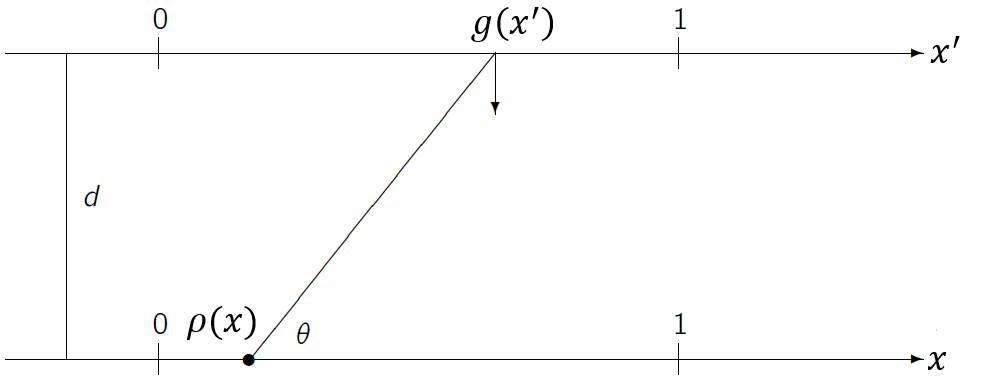

O campo gravitacional de uma parte infinitesimalmente pequena de $\rho(x)$, de comprimento $\text{d}x$, no eixo $x$ é $\rho(x) \text{d}x / r^2$, em que $r = \sqrt{d^2 + (x' - x)^2}$ é a distância entre o "**ponto fonte**" em $x$ e o "**ponto medido em campo**" em $x'$. A direção do campo gravitacional é no sentido: do "ponto medido em campo" para o "ponto fonte" e, portanto, o valor medido de $\text{d}g(x')$ é

\begin{equation}
\text{d}g(x') = \frac{\text{sin}(\theta)}{r^2}\rho(x) \text{d}x
\end{equation}
com $\text{sin}(\theta) = d/r$. O valor total de $g(x')$ consiste na integral da equação anterior, a saber

\begin{equation}
g(x') = \int_{0}^{1}\frac{d}{(d^2+(x' - x)^2)^{3/2}} \rho(x) \text{d}x
\end{equation}
com 

\begin{equation}
K(x',x) = \frac{d}{(d^2+(x' - x)^2)^{3/2}}
\end{equation}

Note que o **kernel** $K(x',x)$ será usado para computar nossa matriz $\textbf{A}$; a dimensão física da densidade é $\rho(x)$ [kg/m] (1D); falta a constante de gravitação universal, $G$ [Nm$^2$/kg$^2$]. O problema servirá para nos ensinar muitos aspectos. 

Vamos definir funções pra computar a matriz $\textbf{A}$ e o campo de densidades, expresso num vetor $\textbf{x}$, que é a causa do que será de fato medido no vetor $\textbf{b}$. 

In [2]:
def gravity_model(n,a,b,d):
    dx = 1/n
    dxl = (b-a)/n
    x = dx * (np.arange(n) + 0.5) 
    xl = a + dxl * (np.arange(n) + 0.5) 
    X,XL = np.meshgrid(x,xl)
    A = dx * (d/(d**2 + (X-XL)**2)**(3/2)) 
    return A

def density_pieciwise(n):
    nn = int(n/3)
    rhox = np.ones(n)
    rhox[:nn] = 2
    return rhox

# $g$ $\times$ $d$ (medição vs. distância)

Investiguemos o que acontece com a aceleração da gravidade medida, ao aumentarmos a distância de medição $d$.

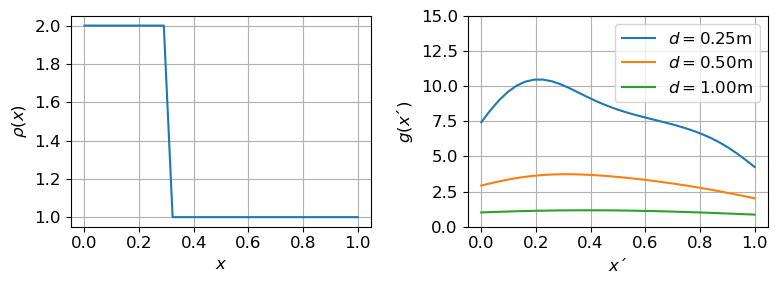

In [3]:
n = 32
a = 0
b = 1
distances = [0.25, 0.5, 1]
rhox = density_pieciwise(n = n)
x = np.linspace(0, 1, n)

g_vs_d = []
for d in distances:
    A = gravity_model(n = n,a = a,b = b,d = d)
    g_vs_d.append(A @ rhox)

    
# Figure
fig, axs = plt.subplots(1, 2, figsize = (8,3))
axs[0].plot(x, rhox)
axs[0].grid(True)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$\rho(x)$')
axs[1].plot(x, g_vs_d[0], label = r'$d = 0.25$m')
axs[1].plot(x, g_vs_d[1], label = r'$d = 0.50$m')
axs[1].plot(x, g_vs_d[2], label = r'$d = 1.00$m')
axs[1].set_ylim((0, 15))
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].set_xlabel(r'$x´$')
axs[1].set_ylabel(r'$g(x´)$')
plt.tight_layout()

- Quanto mais longe medimos da fonte (origem do fenômeno), menor é a amplitude da quantidade medida (consequência).
- Note que neste caso, o termo fonte é uma função com uma desonctinuidade. Por isso, o termo fonte é composto por muitas compoponentes de alta frequência espacial (lembre-se da série de Fourier). 

Se computarmos a Transformada de Fourier do termo fonte teremos:

\begin{equation}
\rho(\text{j}k) = \int_{-\infty}^{\infty}\rho(x) \text{e}^{-\text{j} k x} \text{d}x
\end{equation}
com $k$ sendo o número de onda em [rad/m]. Assim, a transformada espacial de Fourier resulta em:

\begin{equation}
\rho(\text{j}k) = \int_{0}^{1/3}2 \text{e}^{-\text{j} k x} \text{d}x + \int_{1/3}^{1}1 \text{e}^{-\text{j} k x} \text{d}x
\end{equation}

\begin{equation}
\rho(\text{j} k) = -\frac{1}{\text{j}k}\left[\text{e}^{-\text{j} k}+ \text{e}^{-\text{j} k/3}-2\right]
\end{equation}


A função medida, no entanto, é suave.

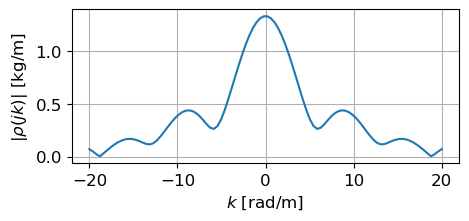

In [4]:
k = np.linspace(-20, 20, 100)
Rhow = (-1/(1j*k))*(np.exp(-1j*k)+np.exp(-1j*k/3)-2)

plt.figure(figsize = (5,2))
plt.plot(k, np.abs(Rhow))
plt.grid()
plt.xlabel(r'$k$ [rad/m]')
plt.ylabel(r'$|\rho(jk)|$ [kg/m]');

# Frequência espacial

Vamos investigar um termo fonte do tipo

\begin{equation}
\rho(x) = \text{sin}(2\pi f_{\rho} x)
\end{equation}
com apenas uma frequência. Podemos variar os falores de $f_{\rho}$.

A suavização da função medida pode ser expressa pelo lema de Riemann–Lebesgue, da seguinte forma:

\begin{equation}
g(x') = \int_{0}^{1}K(x',x) \rho(x) \text{d}x \rightarrow 0, \ \ \ \ \ \ \ \ \text{para} \ \ \ \ \ \ f_p \rightarrow \infty
\end{equation}

Assim, componentes de alta frequência espacial tendem a decair rapidamente.

Note então que a amplitude do fenômeno medido é menor para:
- maiores distâncias
- maiores frequências espaciais no fenômeno de origem

In [5]:
def density_sin(x, fp):
    rhox = np.sin(2*np.pi*fp*x)
    return rhox

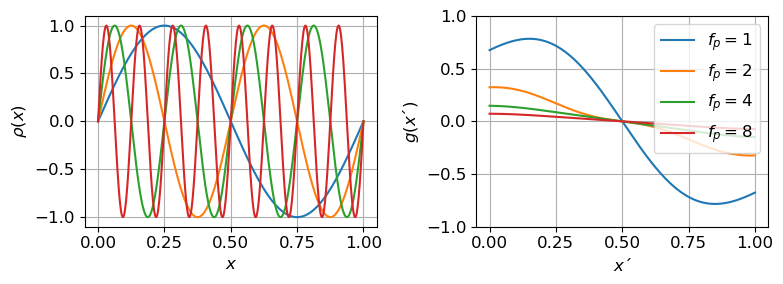

In [6]:
n = 500
a = 0
b = 1
d = 0.5
x = np.linspace(0, 1, n)
fp = [1, 2, 4, 8]
A = gravity_model(n = n,a = a,b = b,d = d)

rhox_vs_fp = []
g_vs_fp = []
for p in fp:
    rhox = density_sin(x, p)
    rhox_vs_fp.append(rhox)
    g_vs_fp.append(A @ rhox)

    
# Figure
fig, axs = plt.subplots(1, 2, figsize = (8,3))
axs[0].plot(x, rhox_vs_fp[0])
axs[0].plot(x, rhox_vs_fp[1])
axs[0].plot(x, rhox_vs_fp[2])
axs[0].plot(x, rhox_vs_fp[3])
axs[0].grid(True)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$\rho(x)$')
axs[1].plot(x, g_vs_fp[0], label = r'$f_p = 1$')
axs[1].plot(x, g_vs_fp[1], label = r'$f_p = 2$')
axs[1].plot(x, g_vs_fp[2], label = r'$f_p = 4$')
axs[1].plot(x, g_vs_fp[3], label = r'$f_p = 8$')
axs[1].set_ylim((-1, 1))
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].set_xlabel(r'$x´$')
axs[1].set_ylabel(r'$g(x´)$')
plt.tight_layout()

### Qual é o problema com a frequência então?

- Ao tentar inferir componentes de alta frequência espacial em $\rho(x)$, a partir de dados medidos em $g(x^{'})$ haverá amplificação.
- Amplitudes menores em $g(x^{'})$ tendem a ser mais corrompidas por ruído.
- Se não formos cautelosos, vamos acabar amplificando ruído e condenando nossa solução.

# SVD (Singular Value Decomposition)

A esta altura nós já aprendemos que escrever funções em termos de funções mais simples e ortogonais é uma ferramenta poderosa. Uma dessas soluções chama-se Singular Value Expansion (SVE), que é a versão contínua da expansão discreta chamada de SVD (Assim como a Transformada de Fourier é a versão contínua da FFT).

Esta não é a única forma de decompor uma matriz, mas com certeza nos ensina muita coisa.

A expansão de uma matriz $\textbf{A} \in \mathbb{R}^{M \times L}$ ($M\geq L$) em **SVD** é uma poderosa ferramenta, especialmente porque se aplica também a **matrizes retangulares**. 

\begin{equation}
\textbf{A} = \textbf{U} \Sigma \textbf{V}^T=\sum\limits_{i=1}^{L}\textbf{u}_i \sigma_i \textbf{v}_{i}^{T}
\end{equation}
em que 

\begin{equation}
\Sigma = \text{diag}(\sigma_1, \sigma_2, ..., \sigma_L), \ \ \ \ \ \ \ \sigma_1 \geq \sigma_2 \geq \cdots \sigma_L
\end{equation}

As matrizes $\textbf{U} \in \mathbb{R}^{M \times L}$ e $\textbf{V} \in \mathbb{R}^{L \times L}$ são compostas por vetores colunas chamados de: 

- left singular vectors: $\textbf{U} = [\textbf{u}_1, \textbf{u}_2, \cdots, \textbf{u}_M]$
- right singular vectors: $\textbf{V} = [\textbf{v}_1, \textbf{v}_2, \cdots, \textbf{v}_L]$

e ambas as matrizes tem colunas ortonormais: $\textbf{u}_{i}^{T}\textbf{u}_{j} = \textbf{v}_{i}^{T}\textbf{v}_{j} = \delta_{ij}$, ou $\textbf{U}^{T}\textbf{U} = \textbf{V}^{T}\textbf{V} = \textbf{I}$. 

Vejamos tais propriedades para um problema pequeno.

In [7]:
n = 8
a = 0
b = 1
d = 0.5
A = gravity_model(n = n,a = a,b = b,d = d)
[U,s,V] = csvd(A)

In [8]:
np.conj(U).T

array([[-0.27559, -0.33651, -0.38205, -0.40602, -0.40602, -0.38205,
        -0.33651, -0.27559],
       [-0.44413, -0.43353, -0.31804, -0.11684,  0.11684,  0.31804,
         0.43353,  0.44413],
       [ 0.49912,  0.24507, -0.13409, -0.41574, -0.41574, -0.13409,
         0.24507,  0.49912],
       [-0.47209,  0.08264,  0.45261,  0.25584, -0.25584, -0.45261,
        -0.08264,  0.47209],
       [ 0.38552, -0.3772 , -0.3065 ,  0.33934,  0.33934, -0.3065 ,
        -0.3772 ,  0.38552],
       [-0.27358,  0.50047, -0.15802, -0.38692,  0.38692,  0.15802,
        -0.50047,  0.27358],
       [ 0.16217, -0.42944,  0.49206, -0.21716, -0.21716,  0.49206,
        -0.42944,  0.16217],
       [-0.07099,  0.23398, -0.41113,  0.52075, -0.52075,  0.41113,
        -0.23398,  0.07099]])

Singular values: [2.52523e+00 9.91037e-01 3.37790e-01 1.04878e-01 3.04869e-02 8.17890e-03
 1.98155e-03 4.13271e-04]


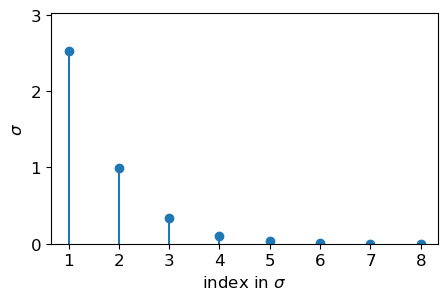

In [9]:
print("Singular values: {}".format(s))

plt.figure(figsize = (5,3))
plt.stem(np.arange(len(s))+1, s, basefmt=" ")
plt.ylim((0, 1.2*np.amax(s)))
plt.xlabel(r'index in $\sigma$')
plt.ylabel(r'$\sigma$')
plt.xticks(np.arange(len(s))+1);

In [10]:
i = 6
j = 6
print(U[:,i] @ U[:,j])
print(V[:,i] @ V[:,j])

1.0000000000000002
0.9999999999999994


# Pseudo inversa

A norma da matriz $\textbf{A}$ pode ser expressa em termos dos valores singulares

\begin{equation}
\left\|\textbf{A}\right\|_{F} = \sqrt{\sum\limits_{i=1}^{L}\sigma_{i}^{2}}
\end{equation}

com 
\begin{equation}
\kappa= \sigma_1
\end{equation}

Se a matriz inversa $\textbf{A}$ existe, então

\begin{equation}
\textbf{A}^{-1} = \textbf{V} \Sigma^{-1} \textbf{U}^T
\end{equation}
com $\Sigma^{-1} = \text{diag}(\sigma_{1}^{-1}, \sigma_{2}^{-1}, \cdots, \sigma_{L}^{-1})$. 

Conseguimos notar um problema aqui? 

- se $\sigma_1 \geq \sigma_2 \geq \cdots \sigma_L$, 
- então $\sigma_{1}^{-1} \leq \sigma_{2}^{-1} \leq \cdots \leq \sigma_{L}^{-1}$ - **amplificação**
- Os valores singulares de menor valor estão associados às componentes de maior frequência espacial - **atenuação**

Note que 

\begin{equation}
\left\|\textbf{A}\right\|_{F}^{-1} = \sqrt{\sum\limits_{i=1}^{L}\sigma_{i}^{-2}}
\end{equation}

com 
\begin{equation}
\kappa= \sigma_{L}^{-1}
\end{equation}

Assim 

\begin{equation}
\text{cond}(\textbf{A}) = \sigma_1/\sigma_{L}
\end{equation}

# O papel do SVD

Dado que $\textbf{A}^{-1} = \textbf{V} \Sigma^{-1} \textbf{U}^T$, podemos escrever

\begin{equation}
\textbf{x} = \textbf{A}^{-1}\textbf{b} = \sum\limits_{i=1}^{L}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

Assim podemos analisar as colunas em $\textbf{U}$ e as **taxas de decaimento** de:

- dos valores singulares: $\sigma_i$
- dos valores: $|\textbf{u}_{i}^{T}\textbf{b}|$
- dos valores: $|\textbf{u}_{i}^{T}\textbf{b}| / \sigma_i$

In [11]:
def plot_colvecs(U):
    fig, axs = plt.subplots(4, 4, figsize = (8,5), sharex=True, sharey=True)
    j = 0
    for row in np.arange(4):
        for col in np.arange(4):
            axs[row,col].plot(U[:,j])
            axs[row,col].set_ylim((-0.2,0.2))
            j += 1
            axs[3,col].set_xlabel(r'$i$')
        axs[row,0].set_ylabel(r'$u$')
    plt.tight_layout()
    
def plot_picard(U,s,b):
    cond_number = s[0]/s[-1]
    beta = np.abs(U.T @ b)
    plt.figure(figsize = (5,4))
    plt.semilogy(np.abs(s), '+k', label = r'$\sigma$')
    plt.semilogy(beta, 'xr', label = r'$|U^T b|$')
    plt.semilogy(beta/s, '.b', label = r'$|U^T b|/\sigma$')
    plt.semilogy(np.finfo(float).eps*s[0]*np.ones(len(s)), '--', linewidth = 2, color = 'Grey', label = r'eps$\cdot \sigma_1$')    
    plt.legend(loc = 'lower left')
    plt.ylim((0.1*s[-1], 100*s[0]))
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\sigma_i$, $|U^Tb|$, $|U^Tb|/\sigma_i$')
    plt.title('cond(A) = {0:.2f}'.format(cond_number), loc='right')
    plt.grid()

In [12]:
n = 64
a = 0
b = 1
d = 0.25
A = gravity_model(n = n,a = a,b = b,d = d)
[U,s,V] = csvd(A)


x = np.linspace(0, 1, n)
rhox = density_sin(x, 0.5) + 0.5* density_sin(x, 1.0)
#rhox = density_pieciwise(n = n)


gxl = A @ rhox

# Colunas em $\textbf{U}$

As colunas em $\textbf{U}$ formam uma base de funções **espectrais** ortogonais para construir $\textbf{x}$. À medida que o índice aumenta, a taxa de oscilação na função também aumenta. Mais uma vez concluímos que:
- Os valores singulares de menor valor estão associados às colunas de $\textbf{U}$ de ordem mais elevada e, portanto às componentes de maior frequência espacial - **atenuação**

O plot de $\textbf{V}^{T}$ resulta no mesmo plot, devido a simetria em $\textbf{A}$.

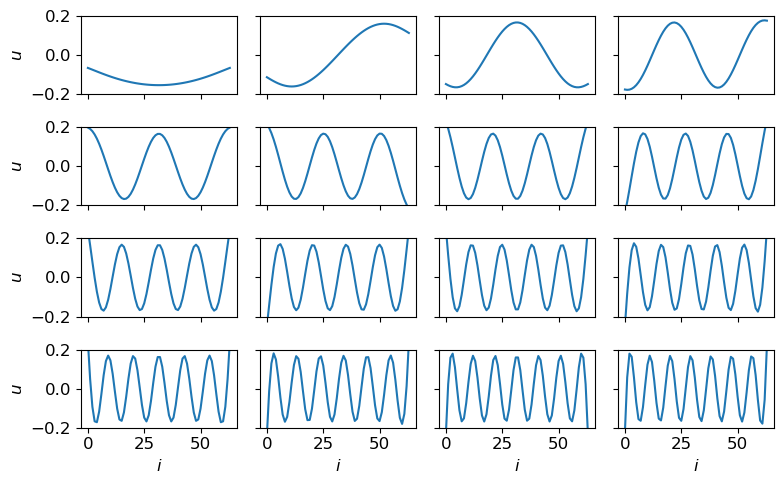

In [14]:
plot_colvecs(U)

# O plot de Picard

Vamos plotar numa curva

- dos valores singulares: $\sigma_i$
- dos valores: $|\textbf{u}_{i}^{T}\textbf{b}|$
- dos valores: $|\textbf{u}_{i}^{T}\textbf{b}| / \sigma_i$

e analisar as taxas de decaimento das funções. Vamos pensar primeiro no caso sem ruído.

condition number: 1.485782530095914e+16


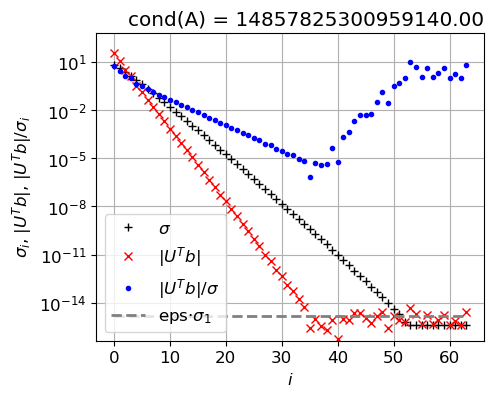

In [15]:
print("condition number: {}".format(s[0]/s[-1]))
plot_picard(U,s,gxl)

## Singular values

Claramente, os valores singulares decaem para zero sem qualquer lacuna em qualquer parte do espectro. Para $i \geq 55$, tendem a estabilizar-se, o que se deve à influência da aritmética de precisão finita (estes pequenos valores singulares são menores do que a precisão da máquina $\times \sigma_1$, e **não são confiáveis**). O $\text{cond}(\textbf{A}) \approx 10^{16}$, o que, para todos os efeitos práticos, é infinito.

## $|\textbf{u}_{i}^{T}b|$ e $|\textbf{u}_{i}^{T}b|/\sigma_i$

Neste caso, os coeficientes $|\textbf{u}_{i}^{T}b|$ decaem mais rapidamente do que os valores singulares, até se estabilizarem para $i \leq 35$ num patamar determinado pela precisão da máquina. Os coeficientes da solução $|\textbf{u}_{i}^{T}b|/\sigma_i$ também decaem para $i \leq 35$, mas para $i \geq 35$ começam a aumentar novamente devido aos valores imprecisos imprecisos de $|\textbf{u}_{i}^{T}b|$.

Isto ilustra que, mesmo sem ruído nos dados, nem sempre podemos esperar calcular uma solução significativa para o problema inverso discreto. A influência dos erros de arredondamento no cálculo da SVD é suficiente para destruir a solução. O mesmo acontece se a solução ingênua $\textbf{x} = \textbf{A}^{-1}\textbf{b}$ for calculada por eliminação gaussiana. 

## E quando há ruído?

noise level at $10^-3.60$


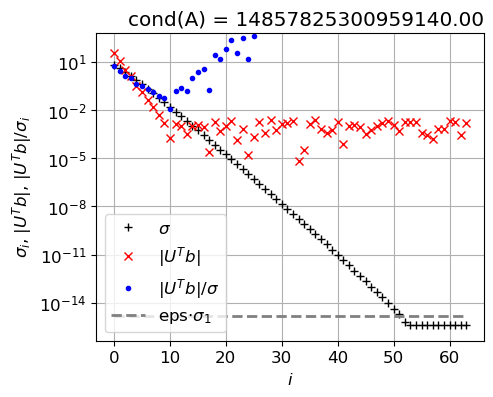

In [16]:
n = np.random.normal(loc = 0.0, scale = 0.001, size = len(gxl))
gxln = gxl + n
print(r"noise level at $10^{0:.2f}$".format(np.log10(np.linalg.norm(n)/np.linalg.norm(gxl))))

plot_picard(U,s,gxln)

vemos um decréscimo inicial inicial dos coeficientes $|\textbf{u}_{i}^{T}b|$ até se estabilizarem num patamar determinado pelo
ruído. Os coeficientes da solução, $|\textbf{u}_{i}^{T}b|/\sigma_i$, também diminuem inicialmente, mas para valores maiores do índice $i$, começam a aumentar novamente. As soluções calculadas são completamente dominadas pelos menores valores singulares  (alta frequência espacial).

# A condição discreta de Picard
> Seja $\tau$ o nível a partir do qual os valores singulares valores singulares computados $\sigma_i$ se nivelam devido a erros de arredondamento. A condição de Picard discreta é satisfeita se, para todos os valores $\sigma_i>\tau$, os coeficientes correspondentes $|\textbf{u}_{i}^{T}b|$, em média, decaem mais rapidamente do que os $\sigma_i$.




# A lição principal

Considere um ruído gaussiano do tipo

\begin{equation}
\textbf{n} = \mathcal{N}(0, \eta^2)
\end{equation}
com média zero e desvio padrão $\eta$. 

Considere também que nós medimos $\textbf{b}$ com ruído, de nodo que:

\begin{equation}
\textbf{b} =\textbf{b}_{\text{exact}} + \textbf{n}  
\end{equation}

Em resumo, existem dois tipos diferentes de coeficientes do lado direito:

- Há coeficientes confiáveis, caracterizados por $|\textbf{u}_{i}^{T}b| > \eta$, que contêm principalmente informação sobre os dados exatos, $\textbf{b}$. Devido à condição discreta de Picard, estes coeficientes correspondem aos maiores valores singulares 
$\sigma_i$

- Existem componentes "ruidosos" do SVD, aqueles para os quais $|\textbf{u}_{i}^{T}\textbf{b}_{\text{exact}}| < \eta$ e para os quais, por conseguinte, $|\textbf{u}_{i}^{T}b| \approx \eta$. Estes coeficientes correspondem aos aos valores singulares, também devido à condição discreta de Picard.

Assim, uma solução sensata faz com que seja necessário que **filtremos** de alguma forma a influência dos valores singulares contaminados por ruído. Isto é o que uma técnica de regularização faz.